In [ ]:
#import libraries
!pip install --upgrade xarray
!pip install --upgrade cdsapi
!pip install --upgrade netCDF4
!pip install --upgrade cartopy
!pip install --upgrade dask
!pip install --upgrade ecmwflibs
!pip install --upgrade eccodes
!pip install --upgrade cfgrib
!pip install --upgrade zarr
!pip install --upgrade fsspec
!pip install --upgrade gcsfs
import os, sys, time, math, datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from matplotlib import gridspec
import xarray as xr
import netCDF4

import cartopy.crs as ccrs

import dask
import zarr
import fsspec
import gcsfs
import cfgrib

In [ ]:
# == If running on Google colab: ==
from google.colab import auth, drive

# Authentification for gcloud
auth.authenticate_user()

# mount google drive
drive.mount("/content/drive")

In [ ]:
#working directory and file names
data_path = '/content/drive/MyDrive/ClimateTransformers/Preprocessed_datasets/'
gt_2020 = data_path + '2021_PNW_heatwave_2020_baseline_gt.nc'
fc_2020 = data_path + '2021_PNW_heatwave_2020_baseline_fc.nc'
gt_2021 = data_path + '2021_PNW_heatwave_gt.nc'
fc_2021 = data_path + '2021_PNW_heatwave_fc.nc'
gt_2022 = data_path + '2021_PNW_heatwave_2022_baseline_gt.nc'
fc_2022 = data_path + '2021_PNW_heatwave_2022_baseline_fc.nc'

#Index and date parameters
pred_interest = 28
n_days_ahead = 5
add_pred = 12
coords_interest = [(49.25,-123.0), (47.5,-122.25), (45.5,-122.75), (50.25,-121.5)]
coords_names = ['Vancouver', 'Seattle', 'Portland', 'Lytton']
save_box_coord = ((60,-130), (40,-110)) #PNW

#extract data for a small region to save memory
#spatial window: 45-52N, 119-123W
lon_min = -123%360 #-60%360
lon_max = -119%360 #-140%360
lat_max = 52
lat_min = 45

#variable of interest
field = '2m_temperature'
field_ERA5HRES = 't2m'

#set output file name
results_path = './Results/RMSE_comparison_baseline/'
os.makedirs(results_path, exist_ok=True)

plt.style.use('tableau-colorblind10')

Define functions to compute the root mean square error of different models' forecast.

In [ ]:
def C_to_K(x):
    # Celsius to Kelvin
    return x + 273.15

def K_to_C(x):
    # Celsius to Kelvin
    return x - 273.15

def coord2loc(coord):
    assert ((coord[0]%0.25 == 0) and (coord[1]%0.25 == 0)), "Only 0.25 coordinate increments are possible."
    loc = (int((90-coord[0])*4), int((coord[1] % 360)*4))
    assert ((loc[0]>=0) and (loc[0]<=721) and (coord[1]>=-180) and (coord[1]<=180)), "Invalid coordinates."
    return loc

#unify dimension names (longitude and latitude)
def rename_latlon(data: xr.DataArray) -> xr.DataArray:
    return data.rename({'longitude': 'lon', 'latitude': 'lat'})

#define latitude-based (or grid cell area-based) weight
def normalized_latitude_weights(data: xr.DataArray) -> xr.DataArray:
    latitude = data.coords['lat']
    weights = np.cos(np.deg2rad(latitude))
    return weights / weights.mean(skipna=False)

#define functions to compute RMSE
def single_forecast_RMSE(forecast: xr.DataArray, truth: xr.DataArray) -> xr.DataArray:
    loss = (forecast - truth)**2
    loss *= normalized_latitude_weights(truth).astype(loss.dtype)
    return np.sqrt(loss.mean())

# redefine the RMSE function so that the time average operation is taken inside the square root
def single_leadtime_RMSE(forecast: xr.DataArray, truth: xr.DataArray) -> xr.DataArray:
    if not all(forecast['time'] == truth['time']):
        raise ValueError("Forecast time does not match ground truth time")
    RMSE = single_forecast_RMSE(forecast, truth)
    return RMSE

#compute RMSE for various leadtimes
def MLmodel_RMSE(forecast: xr.DataArray, truth: xr.DataArray, targettime_start: datetime.datetime,
                   targettime_end: datetime.datetime, UTC618=True, UTC012=True) -> xr.DataArray:
    if UTC012 and UTC618:
        time_mask = (truth.time.dt.hour).isin([0, 6, 12, 18])
    elif UTC618 and not(UTC012):
        time_mask = (truth.time.dt.hour).isin([6,18])
    elif UTC012 and not(UTC618):
        time_mask = (truth.time.dt.hour).isin([0,12])
    else:
        raise ValueError("No evaluation time was chosen")
    truth = truth.where(time_mask, drop=True)
    RMSE = xr.DataArray(None, coords=dict(leadtime=forecast['prediction_timedelta'].values[2::2]), dims=['leadtime'])
    for i, leadtime in enumerate(RMSE['leadtime']):
        forecast_sub = forecast.sel(prediction_timedelta=leadtime, drop=True)
        forecast_sub['time'] = forecast_sub['time'] + leadtime
        forecast_sub = forecast_sub.sel(time=slice(targettime_start, targettime_end))
        forecast_sub = forecast_sub.where(time_mask, drop=True)
        RMSE[i] = single_leadtime_RMSE(forecast_sub, truth)
    return RMSE


#compute RMSE for HRES forecast, leadtime for 6/18h (0/12h) initializations up to 3.5 (10) days
def HRES_RMSE(hres: xr.DataArray, targettime_start: datetime.datetime, targettime_end: datetime.datetime,
              UTC618=True, UTC012=True) -> xr.DataArray:
    truth = hres.isel(prediction_timedelta=0, drop=True).sel(time=slice(targettime_start, targettime_end))
    if UTC012 and UTC618:
        time_mask = (truth.time.dt.hour).isin([0, 6, 12, 18])
    elif UTC618 and not(UTC012):
        time_mask = (truth.time.dt.hour).isin([6,18])
    elif UTC012 and not(UTC618):
        time_mask = (truth.time.dt.hour).isin([0,12])
    else:
        raise ValueError("No evaluation time was chosen")
    truth = truth.where(time_mask, drop=True)
    RMSE = xr.DataArray(None, coords=dict(leadtime=hres['prediction_timedelta'].values[2::2]), dims=['leadtime'])
    for i, leadtime in enumerate(RMSE['leadtime']):
        hres_sub = hres.sel(prediction_timedelta=leadtime, drop=True)
        hres_sub['time'] = hres_sub['time'] + leadtime
        hres_sub = hres_sub.sel(time=slice(targettime_start, targettime_end))
        hres_sub = hres_sub.where(time_mask, drop=True)
        RMSE[i] = single_leadtime_RMSE(hres_sub, truth)
    return RMSE

In [ ]:
######################## load data
# year 2020
forecast_2020 = rename_latlon(xr.load_dataset(fc_2020))
GraphCast2020 = forecast_2020.sel(forecast = 'GraphCast')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
pg_20 = forecast_2020.sel(forecast = 'PanguWeather')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
HRES2020_0012 = forecast_2020.sel(forecast = 'HRES')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
groundtruth_2020 = rename_latlon(xr.load_dataset(gt_2020))
ERA52020 = groundtruth_2020.sel(source='ERA5')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
# year 2021
forecast_2021 = rename_latlon(xr.load_dataset(fc_2021))
GraphCast2021 = forecast_2021.sel(forecast = 'GraphCast')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
pg_21 = forecast_2021.sel(forecast = 'PanguWeather')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
fcn_21 = forecast_2021.sel(forecast = 'FourCastNet')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
HRES2021 = forecast_2021.sel(forecast = 'HRES')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
groundtruth_2021 = rename_latlon(xr.load_dataset(gt_2021))
ERA52021 = groundtruth_2021.sel(source='ERA5')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
# year 2022
forecast_2022 = rename_latlon(xr.load_dataset(fc_2022))
GraphCast2022 = forecast_2022.sel(forecast = 'GraphCast')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
pg_22 = forecast_2022.sel(forecast = 'PanguWeather')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
fcn_22 = forecast_2022.sel(forecast = 'FourCastNet')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
HRES2022 = forecast_2022.sel(forecast = 'HRES')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
groundtruth_2022 = rename_latlon(xr.load_dataset(gt_2022))
ERA52022 = groundtruth_2022.sel(source='ERA5')[field].sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))

In [ ]:
#specify time of interest for evaluation
dates2020 = [6, 1, 7, 31] #June 1 - July 31
dates2021 = [6, 27, 6, 29] #June 27 - June 29
dates2022 = [6, 20, 7, 10] # June 20 - July 10
starttime2020 = datetime.datetime(2020,dates2020[0],dates2020[1])
endtime2020 = datetime.datetime(2020,dates2020[2],dates2020[3],18)
ERA52020_truth = ERA52020.sel(time=slice(starttime2020, endtime2020))
starttime2021 = datetime.datetime(2021,dates2021[0],dates2021[1])
endtime2021 = datetime.datetime(2021,dates2021[2],dates2021[3],18)
ERA52021_truth = ERA52021.sel(time=slice(starttime2021, endtime2021))
starttime2022 = datetime.datetime(2022,dates2022[0],dates2022[1]) #0611
endtime2022 = datetime.datetime(2022,dates2022[2],dates2022[3],18)
ERA52022_truth = ERA52022.sel(time=slice(starttime2022, endtime2022))

#compute RMSE
RMSE_gc2020_0012 = MLmodel_RMSE(forecast=GraphCast2020, truth=ERA52020_truth, targettime_start=starttime2020,
                          targettime_end=endtime2020, UTC618=False, UTC012=True)
RMSE_pg2020_0012 = MLmodel_RMSE(forecast=pg_20, truth=ERA52020_truth, targettime_start=starttime2020,
                          targettime_end=endtime2020, UTC618=False, UTC012=True)
RMSE_hres2020_0012 = HRES_RMSE(HRES2020_0012, targettime_start=starttime2020, targettime_end=endtime2020,
                               UTC618=False, UTC012=True)

RMSE_gc2021_0618 = MLmodel_RMSE(forecast=GraphCast2021, truth=ERA52021_truth, targettime_start=starttime2021,
                          targettime_end=endtime2021, UTC618=True, UTC012=False)
RMSE_pg2021_0618 = MLmodel_RMSE(forecast=pg_21, truth=ERA52021_truth, targettime_start=starttime2021,
                          targettime_end=endtime2021, UTC618=True, UTC012=False)
RMSE_fcn2021_0618 = MLmodel_RMSE(forecast=fcn_21, truth=ERA52021_truth, targettime_start=starttime2021,
                          targettime_end=endtime2021, UTC618=True, UTC012=False)
RMSE_hres2021_0012 = HRES_RMSE(HRES2021, targettime_start=starttime2021, targettime_end=endtime2021,
                               UTC618=False, UTC012=True)
RMSE_hres2021_0618 = HRES_RMSE(HRES2021, targettime_start=starttime2021, targettime_end=endtime2021,
                               UTC618=True, UTC012=False)

RMSE_gc2022_0618 = MLmodel_RMSE(forecast=GraphCast2022, truth=ERA52022_truth, targettime_start=starttime2022,
                          targettime_end=endtime2022, UTC618=True, UTC012=False)
RMSE_pg2022_0618 = MLmodel_RMSE(forecast=pg_22, truth=ERA52022_truth, targettime_start=starttime2022,
                          targettime_end=endtime2022, UTC618=True, UTC012=False)
RMSE_fcn2022_0618 = MLmodel_RMSE(forecast=fcn_22, truth=ERA52022_truth, targettime_start=starttime2022,
                          targettime_end=endtime2022, UTC618=True, UTC012=False)
RMSE_hres2022_0012 = HRES_RMSE(HRES2022, targettime_start=starttime2022, targettime_end=endtime2022,
                               UTC618=False, UTC012=True)
RMSE_hres2022_0618 = HRES_RMSE(HRES2022, targettime_start=starttime2022, targettime_end=endtime2022,
                               UTC618=True, UTC012=False)

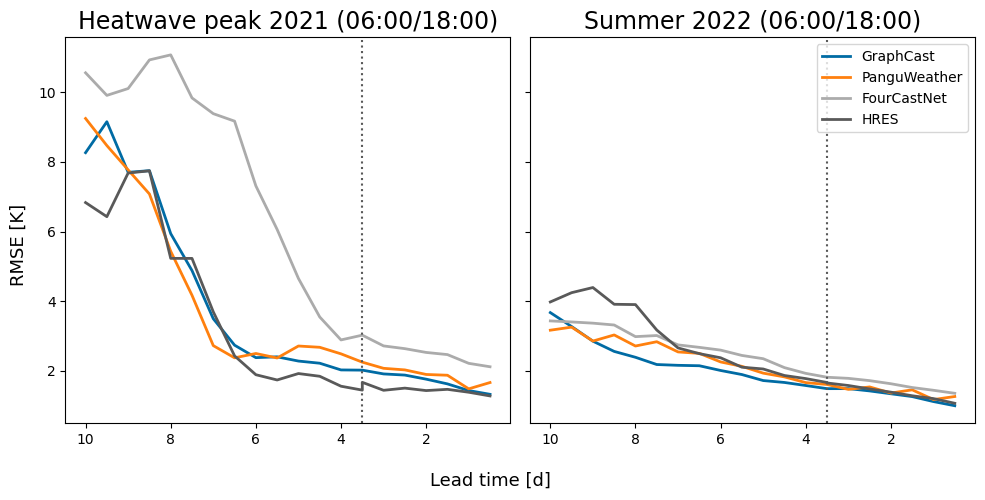

In [ ]:
########################################## Plot RMSE 06/18 mixed ########################################
xlab = np.arange(0.5, 10.1, 0.5)
#change units from Kelvin to degrees Celsius by subtrascting 273.15
f, (p02, p12) = plt.subplots(1, 2, sharex='all', sharey='all', width_ratios=[1, 1])

p02.plot(xlab, RMSE_gc2021_0618, label='GraphCast', linewidth=2, color='C0')
p02.plot(xlab, RMSE_pg2021_0618, label='PanguWeather', linewidth=2, color='C1')
p02.plot(xlab, RMSE_fcn2021_0618, label='FourCastNet', linewidth=2, color='C2')
p02.plot(np.concatenate((xlab[:7], xlab[6:]), axis=0),
         np.concatenate((RMSE_hres2021_0618[:7], RMSE_hres2021_0012[6:]), axis=0),
         label='HRES', linewidth=2, color='C3')
# Add a vertical line
p02.axvline(x=xlab[6], linestyle='dotted', linewidth=1.5, color='C3')
# Adding a plot title and customizing its font size
p02.set_title('Heatwave peak 2021 (06:00/18:00)', fontsize=17)
# Adding axis labels and customizing their font size
#p02.set_xlabel('Lead time (days)', fontsize=13)
# p02.invert_xaxis()

p12.plot(xlab, RMSE_gc2022_0618, label='GraphCast', linewidth=2, color='C0')
p12.plot(xlab, RMSE_pg2022_0618, label='PanguWeather', linewidth=2, color='C1')
p12.plot(xlab, RMSE_fcn2022_0618, label='FourCastNet', linewidth=2, color='C2')
p12.plot(np.concatenate((xlab[:7], xlab[6:]), axis=0),
         np.concatenate((RMSE_hres2022_0618[:7], RMSE_hres2022_0012[6:]), axis=0),
         label='HRES', linewidth=2, color='C3')
# Add a vertical line
p12.axvline(x=xlab[6], linestyle='dotted', linewidth=1.5, color='C3')
# Adding a plot title and customizing its font size
p12.set_title('Summer 2022 (06:00/18:00)', fontsize=17)
# Adding axis labels and customizing their font size
#p12.set_xlabel('Lead time (days)', fontsize=13)
# p12.invert_xaxis()
p12.legend(loc="upper right")

f.gca().invert_xaxis()
f.supylabel('RMSE [K]', fontsize=13)
f.supxlabel('Lead time [d]', fontsize=13)
f.set_figheight(5)
f.set_figwidth(10)
f.tight_layout()
#f.savefig(outfig_file)
f.savefig(results_path + 'RMSE_comparison_06270629_0618mixed_updated.pdf')

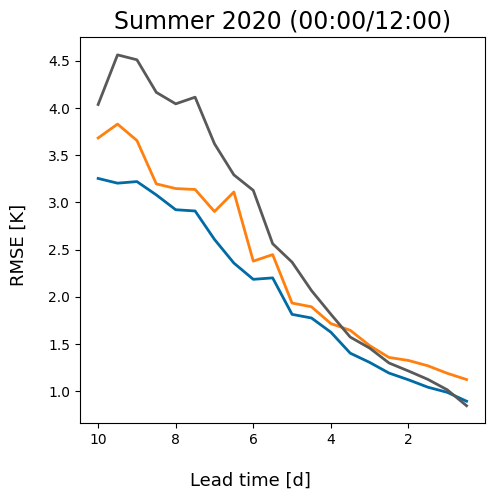

In [ ]:
########################################## Plot RMSE 2020 ########################################
xlab = np.arange(0.5, 10.1, 0.5)
#change units from Kelvin to degrees Celsius by subtrascting 273.15
f, p00 = plt.subplots(1, 1, sharex='all', sharey='all')

p00.plot(xlab, RMSE_gc2020_0012, label='GraphCast', linewidth=2, color='C0')
p00.plot(xlab, RMSE_pg2020_0012, label='PanguWeather', linewidth=2, color='C1')
p00.plot(xlab, RMSE_hres2020_0012, label='HRES', linewidth=2, color='C3')
# Adding a plot title and customizing its font size
p00.set_title('Summer 2020 (00:00/12:00)', fontsize=17)
p00.legend(loc="upper right")

f.gca().invert_xaxis()
f.supylabel('RMSE [K]', fontsize=13)
f.supxlabel('Lead time [d]', fontsize=13)
f.set_figheight(5)
f.set_figwidth(5)
f.tight_layout()
f.savefig(results_path + 'RMSE_comparison_2020.pdf')